# Marketing campaign 

In [88]:
import pandas as pd
import numpy as np
from scipy import stats
import os, json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn import tree, ensemble, metrics, preprocessing 
from sklearn.preprocessing  import LabelEncoder, StandardScaler , RobustScaler,MinMaxScaler
#from sklearn import linear_model 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest, StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, f1_score, roc_auc_score
import optuna
import pickle

# Hides output while after model learned
from IPython.display import clear_output

#from collections import OrderedDict
random_seed=42
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

path_figures = '../figures/'
path_models = '../models/'

## 1. Problem definition

A bank initiated the marketing campaign among its clients to deposit money. After it was finished, the management decided to identfy success factors of the campaign using machine learning algorythm to increase its efficiency and decrease costs.

## 2. EDA

### Bank client data:

* **Age** (numeric)
* **Job** : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* **Marital** : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* **Education** (categorical: 'primary', 'secondary', 'tertiary', 'unknown')
* **Default**: has credit in default? (categorical: 'no', 'yes', 'unknown')
* **Housing**: has housing loan? (categorical: 'no', 'yes', 'unknown')
* **Loan**: has personal loan? (categorical: 'no', 'yes', 'unknown')

### Related with the last contact of the current campaign:

* **Contact**: contact communication type (categorical:
'cellular','telephone')
* **Month**: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
* **Day**: last contact day of the month (numerical)
* **Duration**: last contact duration, in seconds (numeric). Important
note: this attribute highly affects the output target (e.g., if
duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic
predictive model.


### Other attributes:

* **Campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* **Pdays**: number of days that passed by after the client was last
contacted from a previous campaign (numeric; -1 means client was not previously contacted)
* **Previous**: number of contacts performed before this campaign and for this client (numeric)
* **Poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
Social and economic context attributes.

### Target value:

* **deposit** : has the client subscribed a term deposit? (binary: 'yes', 'no')

In [89]:
df = pd.read_csv('../data/campaign.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


## missing entries

In [90]:
cols_null_percent = df.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

balance    0.223974
dtype: float64

In [91]:
df['balance'].isna().value_counts()

False    11137
True        25
Name: balance, dtype: int64

Luckily only 'balance' feature contains 25 missing data entries. 

### Job

In [92]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

It is likely missed values are marked as 'unknown' though they aren't empty. Thus there is no reason to delete them. 

In [93]:
# Cleaning 'job' feature
df['job'] = df['job'].apply(lambda x:  df['job'].mode()[0] if x=='unknown' else x)
df['job'].mode()[0]

'management'

### Education

In [94]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [95]:
# Cleaning 'education' feature
df['education'] = df['education'].apply(lambda x:  df['education'].mode()[0] if x=='unknown' else x)
df['education'].mode()[0]

'secondary'

### Balance

In [96]:
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

We can see that entries ends with a dollar symbol and commas like ',00 $'. The feature's type is 'object'. Special symbols and spaces must be removed; commas should be replaced to dots. At last, we will change column type to numerical.

In [97]:
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ', '')\
    .replace('$', '').replace(',', '.')).astype('float')
    
#print(df['balance'].mean().round(3))
print('Feature type: ', df['balance'].dtype)
print(df['balance'].isna().value_counts())

Feature type:  float64
False    11137
True        25
Name: balance, dtype: int64


In [98]:
# fill empty values with median
df['balance'] = df['balance'].fillna(df['balance'].median())
print(df['balance'].isna().value_counts())
print('Mean balance: {} $'.format(df['balance'].mean().round(3)))

False    11162
Name: balance, dtype: int64
Mean balance: 1526.936 $


In [99]:
fig = px.box(
    data_frame=df, 
    x='balance'
)

fig.update_layout(
    title=dict(text="Fig.1 - Customers' balances distribution", x=.5, y=0.01, xanchor='center'),
    xaxis_title_text = 'Balance, $',
    width=800, height=200,
    margin=dict(l=100, r=60, t=80, b=70),
)
#fig.show()
fig.write_image('../figures/fig_1.png')

<center> <img src="../figures/fig_1.png"></center>

Let us delete outliers using Tukey method

In [100]:
def outliers_tukey(data:pd.DataFrame, feature:str, log_scale=False):
    """
    Identification of outliers by J.Tukey method
    - DataFrame;
    - feature to process
    - log_scale. If True, the data will be in the log scale else not.
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
        
    IQR = data[feature].quantile(.75) - df['balance'].quantile(.25)
  
    lower_bound = data[feature].quantile(.25) - 1.5*IQR
    upper_bound = data[feature].quantile(.75) + 1.5*IQR 
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print('Boundaries: ',lower_bound.round(), upper_bound.round())
    return outliers, cleaned

outliers, data = outliers_tukey(df, 'balance')
print(f'Number of outliers: {outliers.shape[0]}')

data.head()

Boundaries:  -2241.0 4063.0
Number of outliers: 1057


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## EDA

### Target value classes balance

no     0.54
yes    0.46
Name: deposit, dtype: float64


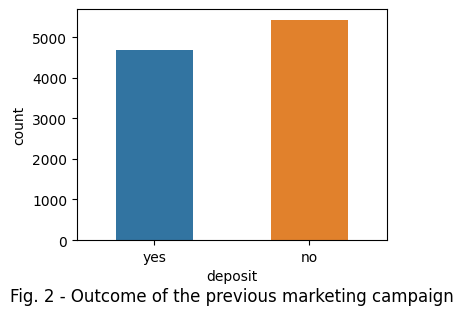

In [101]:
fig, ax = plt.subplots(figsize=(4, 3)) 
sns.countplot(data=data, x='deposit', width=0.5)
ax.set_title('Fig. 2 - Outcome of the previous marketing campaign', y=-0.3);

plt.savefig('../figures/fig_2.png')

print(data['deposit'].value_counts(True).round(2))

Classes of the target value are almost balanced.

### Numeric features

In [102]:
# selection of numerical features
num_features = [s for s in data.columns if data[s].dtypes != 'object']
data[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,10104.0,40.895487,11.735511,18.0,32.0,38.0,48.00,95.0
balance,10104.0,807.331354,993.673452,-2049.0,95.0,444.5,1224.75,4062.0
day,10104.0,15.590657,8.441852,1.0,8.0,15.0,22.00,31.0
duration,10104.0,368.777712,346.650712,2.0,137.0,252.0,490.00,3881.0
campaign,10104.0,2.516924,2.707180,1.0,1.0,2.0,3.00,43.0
pdays,10104.0,51.307700,109.643031,-1.0,-1.0,-1.0,2.00,854.0
previous,10104.0,0.816112,2.243875,0.0,0.0,0.0,1.00,58.0


#### Feature study:

* **age** - Maximal client age is 95 years, that is rather an outlier. Data shape is log-normal with positive skew. It indicates that most of clients are aged: $40.8 \pm 11.7$ years. Age is not interrelated with the target variable - deposit.
* **balance** - Feature is log-normally distributed. Notably, sums on clients' coounts are relatively small: [-2049; 4062] $ with a peak around $0. Most clients have positive balance. The feature has a weak direct relationship with the target.
* **day** - Feature is not normally disributed. Low client activity is observerd at 11 and 24th day after the contact, тогда как высокая - в районе 6, 20 и 30 дней.  
* **duration** - распределение лог-нормальное с сильной положительной ассимметрией. В среднем контакт с клиентами длился $6 \pm 6$ мин (или $369 \pm 365$ сек.). Медианное время контакта довольно непродолжительное и составляет 4,2 мин (или 252 сек). Минимальная и максимальная длительности разговора - 2 и 3881 сек(1 час 4 мин) соответственно. Крайние значения, скорее всего, являются выбросами. Признак слабо коррелирует с целевым (коэффициент корреляции 0,45).
* **campaign** - количество контактов с клиентом во время текущей компании есть дискретная случайная величина, которая распределена не нормально. С каждым клиентом контактировали минимум 1 раз, а в среднем $2.5 \pm 2.7$ раз. Максимум контактов с кодним клиентом - 43 раза, что похоже на выброс. Количество контактов очень слабо отрицательно коррелирует с целевой переменной. Это можно интерпретировать так, что часть клиентов отказалась от депозита после контакта с сотрудниками, проводившими маркетинговую компанию.
* **pdays** - кол-во пропущенных количество дней от последней маркетинговой компании до контакта имеет неравномерное прямоугольное распределение. Признак распределен ненормально: имеет положительную ассимметрию и множество выбросов. Данные совокупности находятся  в диапазоне [-1; 854]. Предположим, что под отрицательными значениями понимается отсутстви контактов с клиентом. Если их не учитывать, то медианное время составляет $182 \pm 123$ дня. Признак очень слабо положительно коррелирует с целевой переменной,- открытие депозита. Это может означать, что контакт с клиентом положительно влияет на открытие депозита.
* **previous** - количество контактов с клиентом до текущей компании. С подавляющим большинством клиентов совокупности контактов не было. Признак имеет лог-нормальное распределение и содержит множество выбросов. Если не учитывать клиентов, с которыми контактировали впервые, то медианное количество контактов равно 2. Признак очень слабо положительно коррелирует с целевой переменной.

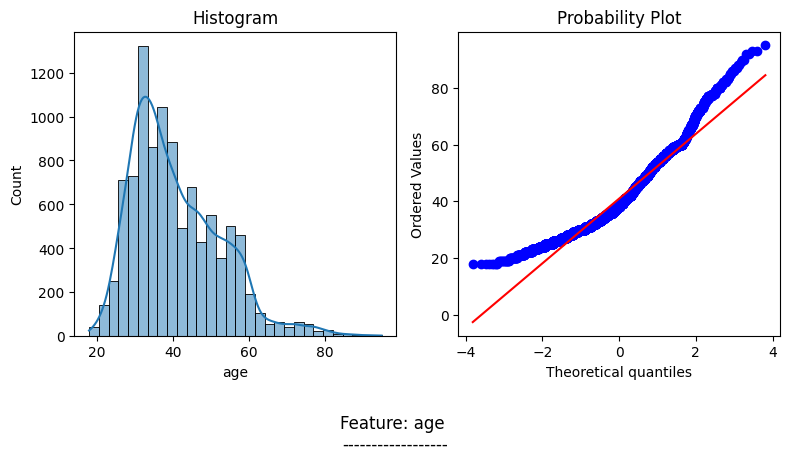

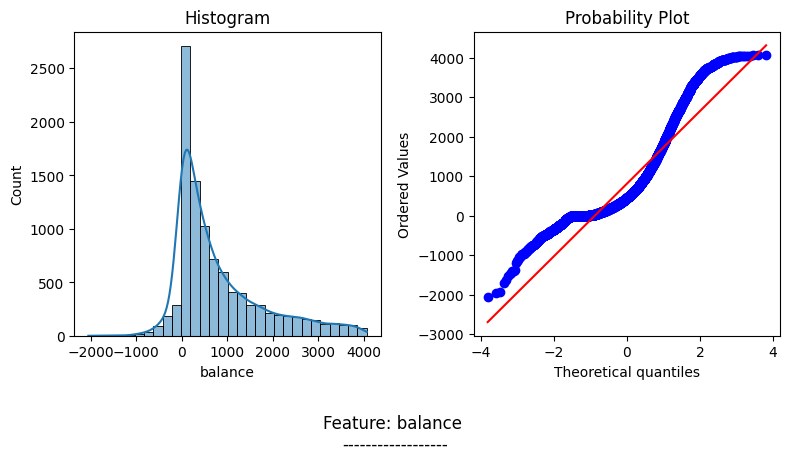

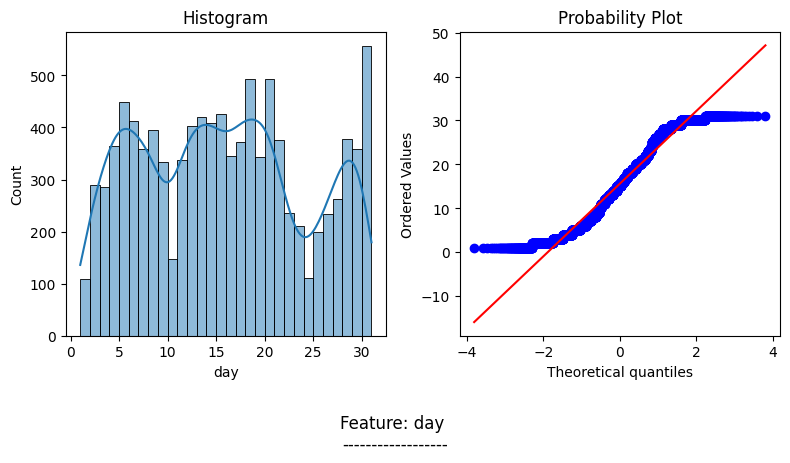

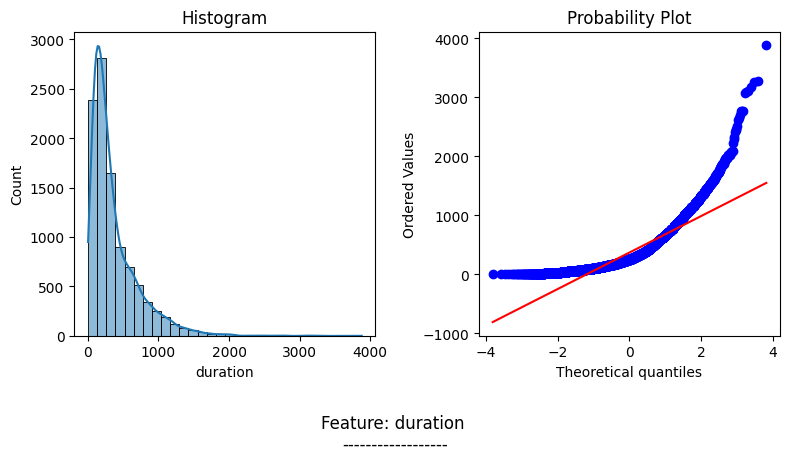

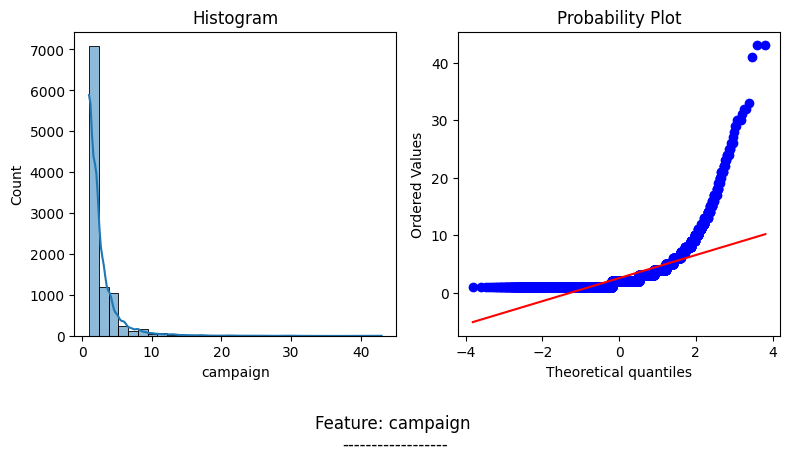

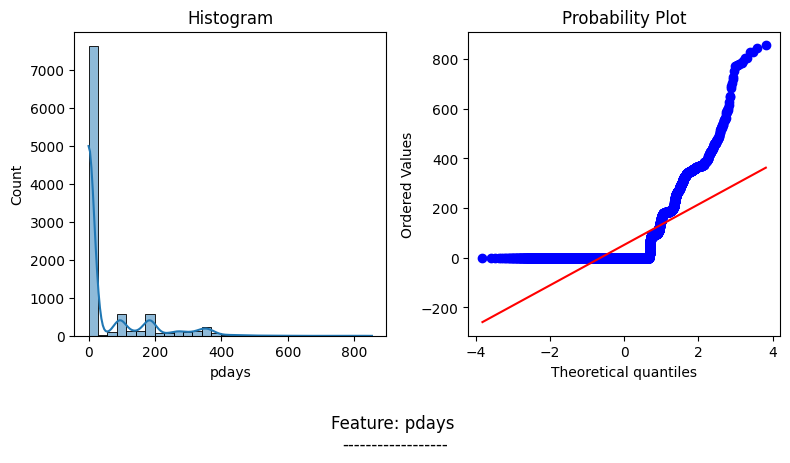

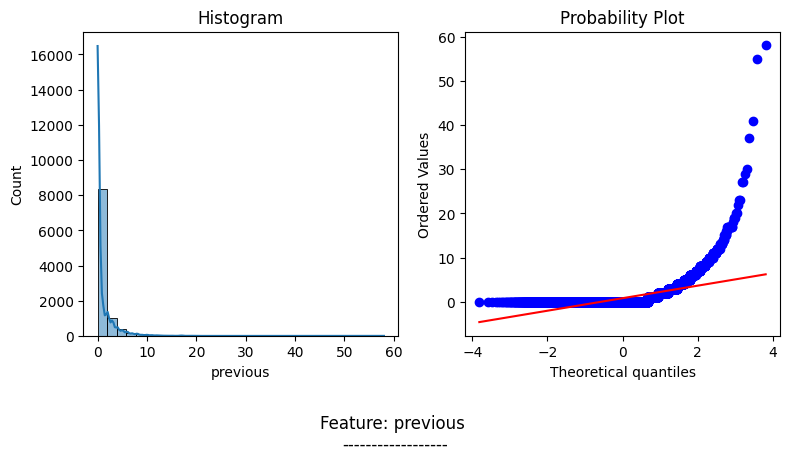

In [121]:
def qq_plot(data, features):
    # display pair plots
    for i in data[features]:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        
        sns.histplot(data[i], kde=True, bins=30, ax=ax[0]) # histogram
        ax[0].set_title('Histogram')

        stats.probplot(data[i], plot=ax[1]) # qq plot
        plt.tight_layout() 
        fig.suptitle(f'Feature: {i} \n------------------', y=-0.05)


qq_plot(data, num_features)

In [104]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True )
    
fig.add_trace(go.Box(x=data['pdays'], name='original'), row=1, col=1)
fig.add_trace(go.Box(x=data[data['pdays'] >0]['pdays'], name='excluding -1 class'), row=2, col=1, )

fig.update_layout(
    title=dict(text="Fig.3 - Days since the last marketing campaign (Pdays) distribution", x=.5, y=0.01, xanchor='center'),
    legend_title_text ='Pdays feature', xaxis2_title_text='Days',
    width=700, height=300,
    margin=dict(l=100, r=60, t=80, b=70))

fig.show()
fig.write_image('../figures/fig_3.png')

In [105]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True )
    
fig.add_trace(go.Box(x=data['previous'], name='original'), row=1, col=1)
fig.add_trace(go.Box(x=data[data['previous'] >0]['previous'], name='excluding 0 class'), row=2, col=1, )

#fig.update_layout(legend_title_text ='previous feature', xaxis2_title_text='Days')

fig.update_layout(
    title=dict(text="Fig.4 - Number of contacts since the last campaign (previous) distribution", x=.5, y=0.01, xanchor='center'),
    legend_title_text ='Previous feature', 
    xaxis2_title_text='Days',
    width=700, height=300,
    margin=dict(l=100, r=60, t=80, b=70))

fig.show()
fig.write_image('../figures/fig_4.png')


In [106]:
#data['deposit_outcome'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [107]:
#data[['previous', 'deposit_outcome']].corr()['deposit_outcome'][0].round(2)

In [108]:
# encoding target
data['deposit_enc'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [109]:
# n = len(num_features) # numerical features
# fig, axes = plt.subplots(n, 2, figsize=(10, 20)) 

# # Cycle to study features
# for i, feature in enumerate(num_features): #i- index, feature    
#     # histogram
#     histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
#     histplot.set_title('{} hist'.format(feature))   
#     histplot.xaxis.set_tick_params(rotation=45)
    
#     # scatter plot with regression
#     regplot = sns.regplot(data=data, x=feature, y='deposit_enc', ax=axes[i][1])
#     regplot.set_title('{} VS deposit'.format(feature));
#     regplot.xaxis.set_tick_params(rotation=45)
           
# plt.tight_layout() 

In [110]:
for feature in num_features: #i- index, feature  
    print('Correlation between {} and target is {}'.format(feature, data[[feature, 'deposit_enc']].corr()['deposit_enc'][0].round(2)))

Correlation between age and target is 0.02
Correlation between balance and target is 0.14
Correlation between day and target is -0.06
Correlation between duration and target is 0.46
Correlation between campaign and target is -0.13
Correlation between pdays and target is 0.15
Correlation between previous and target is 0.14


## Category features

In [111]:
# selection of categorical features
cat_features = [s for s in data.columns if data[s].dtypes == 'object']
data[cat_features].describe().T

,count,unique,top,freq
job,10104,11,management,2314
marital,10104,3,married,5714
education,10104,3,secondary,5517
default,10104,2,no,9938
housing,10104,2,no,5243
loan,10104,2,no,8711
contact,10104,3,cellular,7282
month,10104,12,may,2616
poutcome,10104,4,unknown,7570
deposit,10104,2,no,5423


Категориальные признаки: 
* **month** - месяц, в котором состоялся последний контакт. В списке присутствуют  12 разных месяцев. При отсутствии уточняющих данных можно предположить, что маркетинговая кампания длилась год.
* 

### poutcome

In [112]:
data['poutcome'].value_counts()

unknown    7570
failure    1108
success     945
other       481
Name: poutcome, dtype: int64

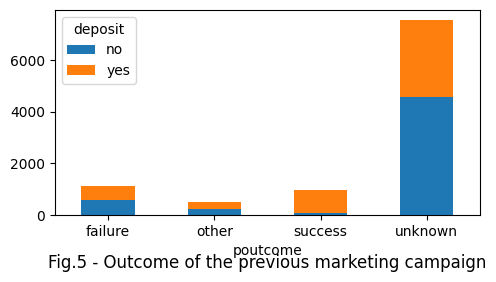

In [113]:
types = data.groupby("poutcome")['deposit'].value_counts().unstack()
fig, ax = plt.subplots(figsize=(5, 3)) 
types.plot(kind='bar', stacked='True', ax=ax)
ax.tick_params(axis='x', rotation=0)
ax.set_title('Fig.5 - Outcome of the previous marketing campaign', y=-0.3);
plt.tight_layout()

plt.savefig('../figures/fig_5.png')

#### Poutcome by months

,month,failure,other,success,unknown,ratio
2,dec,11,12,28,42,0.549020
11,sep,46,31,91,110,0.541667
1,aug,84,36,137,1128,0.533074
6,jun,48,28,84,944,0.525000
10,oct,62,20,90,163,0.523256
5,jul,42,26,64,1286,0.484848
7,mar,26,20,42,149,0.477273
3,feb,127,55,93,434,0.338182
4,jan,39,36,37,207,0.330357
9,nov,139,40,85,516,0.321970


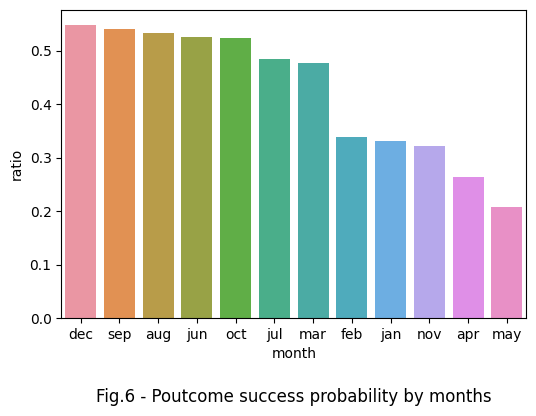

In [114]:
temp=data.groupby(['month','poutcome']).agg('count')[['deposit']].unstack() #

temp.columns = ['failure', 'other','success','unknown']

temp = temp.reset_index()
temp['ratio'] = temp['success']/(temp['failure']+temp['success']+temp['other'])
temp = temp.sort_values(by='ratio', ascending=False)
display(temp)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.barplot(data=temp, x='month', y="ratio",  ax=ax) #
ax.set_title('Fig.6 - Poutcome success probability by months', y=-0.3);

plt.savefig('../figures/fig_6.png')

### Deposit by age group

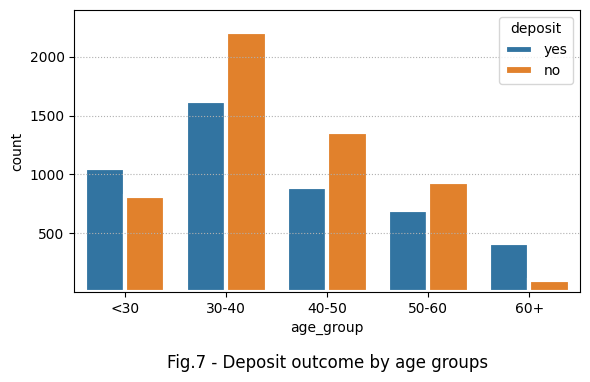

In [115]:
data['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
#data['age_group'] = data['age_group'].astype('category')

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.countplot(data=data, x="age_group", hue="deposit", ax=ax, edgecolor="w",linewidth=3)
ax.set_title('Fig.7 - Deposit outcome by age groups', y=-0.3)
#ax.grid()
ax.yaxis.grid(linestyle=':')
major_ticks = np.linspace(500, 2500, 5)
ax.set_yticks(major_ticks)
ax.set_ylim(0,2400);
plt.tight_layout()

plt.savefig('../figures/fig_7.png')

In [116]:
print('Rate of customers deposited money by age groups:')
pivot = data.groupby("age_group")['deposit'].value_counts(normalize=False).unstack().reset_index(names='age_group')
pivot['ratio'] = (pivot['yes']/ (pivot['yes'] + pivot['no'])).round(2)
pivot.sort_values(by='ratio', ascending=False)

Rate of customers deposited money by age groups:


deposit,age_group,no,yes,ratio
4,60+,97,416,0.81
0,<30,819,1051,0.56
3,50-60,933,692,0.43
1,30-40,2215,1627,0.42
2,40-50,1359,895,0.40


### Deposit by marital

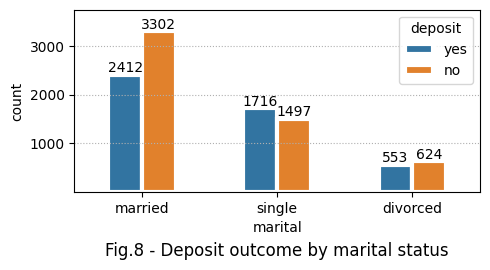

In [117]:
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.countplot(data=data, x='marital', hue='deposit', width=0.5, edgecolor="w",linewidth=3)
ax.set_title('Fig.8 - Deposit outcome by marital status', y=-0.4)
for container in ax.containers:
    ax.bar_label(container)

major_ticks = np.linspace(1000, 3000, 3)
ax.set_yticks(major_ticks)
ax.set_ylim(0,3750)
ax.yaxis.grid(linestyle=':');
plt.tight_layout()

plt.savefig('../figures/fig_8.png')

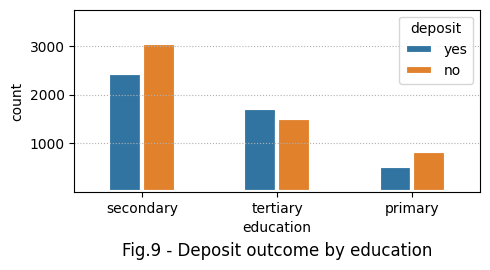

In [118]:
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.countplot(data=data, x='education', hue='deposit', width=0.5, edgecolor="w",linewidth=3)
ax.set_title('Fig.9 - Deposit outcome by education', y=-0.4)
major_ticks = np.linspace(1000, 3000, 3)
ax.set_yticks(major_ticks)
ax.set_ylim(0,3750)
ax.yaxis.grid(linestyle=':');
plt.tight_layout()

plt.savefig('../figures/fig_9.png')

### Deposit by job

In [119]:

fig = px.histogram(data_frame=data, y='job', color='deposit').update_yaxes(categoryorder='total ascending')
fig.update_layout(
    title=dict(text='Fig.10 - Deposit outcome by job', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'job title',
    width=600, height=400,)
fig.show()

fig.write_image('../figures/fig_10.png')

### Deposit by marital and education

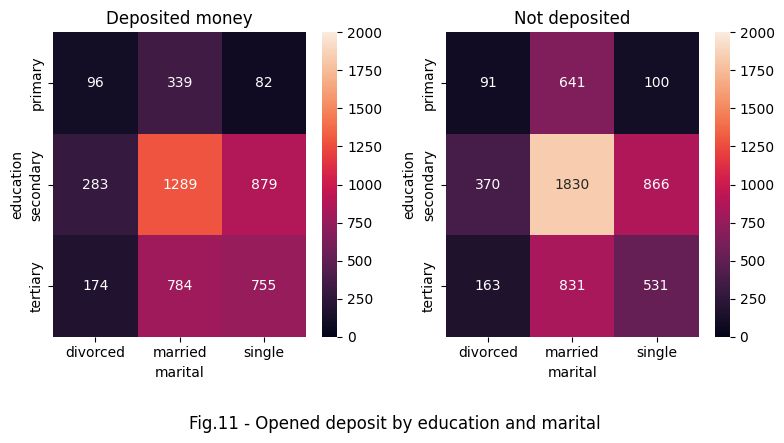

In [120]:
pivot_opened = data[data['deposit']=='yes'].pivot_table(
    values='deposit', 
    index='education', 
    columns='marital', 
    aggfunc='count')

pivot_not_opened = data[data['deposit']=='no'].pivot_table(
    values='deposit', 
    index='education', 
    columns='marital', 
    aggfunc='count')


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

fig = sns.heatmap(pivot_opened, annot=True, fmt=".0f", ax=ax[0], vmin=0, vmax=2000)
fig = sns.heatmap(pivot_not_opened, annot=True, fmt=".0f", ax=ax[1], vmin=0, vmax=2000)

ax[0].set_title('Deposited money')
ax[1].set_title('Not deposited')
plt.tight_layout()
plt.suptitle('Fig.11 - Opened deposit by education and marital', y=-0.05);


plt.savefig('../figures/fig_11.png')

## Feature engineering

### Education

In [34]:
data['education'].value_counts()

secondary    5517
tertiary     3238
primary      1349
Name: education, dtype: int64

In [35]:
# # Encoding
# le = LabelEncoder()
# data['education'] = le.fit_transform(data['education'])
# #data['age_group'] = le.fit_transform(data['age_group'])

# data.head()

### Day

In [36]:
data['day_of_week'] = data['day'].apply(lambda x: x if x<=6 else x%6)+1
data['day_of_week'].value_counts(True)

3    0.179830
6    0.170823
4    0.166568
2    0.154097
5    0.145586
1    0.142221
7    0.040875
Name: day_of_week, dtype: float64

In [37]:
# Assign categorical names
data['day_of_week'] = data['day_of_week'].astype('category').cat.rename_categories({1:'Mon',2:'Tue',3:'wed', 4:'Thu',5:'Fri',6:'Sat',7:'Sun'}).astype('category')

# drop original feature
data.drop(['day'], axis=1, inplace=True)

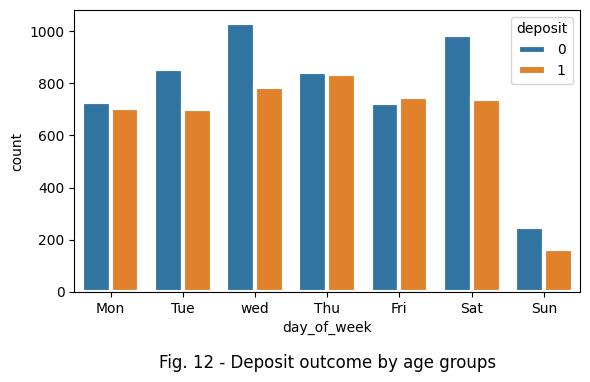

In [82]:
fig, ax = plt.subplots(figsize=(6, 4)) 
sns.countplot(data=data, x='day_of_week', hue="deposit", 
              ax=ax, edgecolor="w",linewidth=3
              )
ax.set_title('Fig. 12 - Deposit outcome by age groups', y=-0.3);
plt.tight_layout()

plt.savefig('../figures/fig_12.png')

### pdays

In [39]:
# data['first_contated'] = data['pdays'].apply(lambda x: 'yes' if x==-1 else 'no')
# data['first_contated'].value_counts(True)

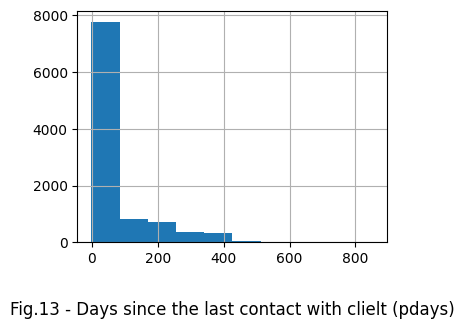

In [40]:
fig, ax = plt.subplots(figsize=(4, 3))
data['pdays'].hist()
ax.set_title('Fig.13 - Days since the last contact with clielt (pdays)', y=-0.35);


In [41]:
# # divide by periods
# period_labels = ['not_contacted','1w','2w','1m','3m','6m','more_6m']
# data['pmonths'] = pd.cut(data['pdays'], [-2,0,7,14,30,90,180,999], labels = period_labels).astype('category')

# fig, ax = plt.subplots(figsize=(6, 3)) 
# sns.histplot(data['pmonths'], hue_order=period_labels, linewidth=1, edgecolor='w')
# ax.set_yscale('log')
# ax.yaxis.grid(linestyle=':')
# ax.xaxis.set_tick_params(rotation=20)
# #ax.legend([]);
# #plt.margins(0.05,0.05)

# #fig.subplots_adjust(bottom=0.2)#left=0.1, right=0.9, top=0.9, bottom=0.1
# plt.tight_layout(pad=0.05);

# # drop original feature
# data.drop('pdays', axis=1, inplace=True)

In [42]:
# upd categorial features
cat_features = [s for s in data.columns if data[s].dtypes == 'object' or data[s].dtypes == 'category']

# cycle by categorical features
for i in  cat_features:
    # encoding if a feature contains 2 unique values such as 'yes' and 'no'
    if data[i].nunique() == 2:
        print(i)
        data[i] = data[i].apply(lambda x: 1 if x=='yes' else 0)#.astype(np.int32)
        
data[cat_features].head(1)

default
housing
loan
deposit


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit,age_group,day_of_week
0,admin.,married,secondary,0,1,0,unknown,may,unknown,1,50-60,Sat


In [43]:
# Missing values identification
cols_null_percent = round(data.isnull().mean() * 100, 2)
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
print(f"Features with missing values, %: \n{cols_with_null}")

Features with missing values, %: 
Series([], dtype: float64)


### Encoding categorial features

In [44]:
# delete duplicated feature 'deposit' and restore an original name
data.drop(['deposit'], axis=1, inplace=True)

# delete 'duration'
data.drop(['duration'], axis=1, inplace=True)
data.rename(columns={'deposit_enc':'deposit'}, inplace=True)

In [45]:
# Encoding
cat_features = [s for s in data.columns if data[s].dtypes == 'object' or data[s].dtypes == 'category']

data_encoded = pd.get_dummies(data) #, columns = cat_features
data_encoded.head()

,age,default,balance,housing,loan,campaign,pdays,previous,deposit,job_admin.,...,age_group_40-50,age_group_50-60,age_group_60+,day_of_week_Mon,day_of_week_Tue,day_of_week_wed,day_of_week_Thu,day_of_week_Fri,day_of_week_Sat,day_of_week_Sun
0,59,0,2343.0,1,0,1,-1,0,1,1,...,0,1,0,0,0,0,0,0,1,0
1,56,0,45.0,0,0,1,-1,0,1,1,...,0,1,0,0,0,0,0,0,1,0
2,41,0,1270.0,1,0,1,-1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
3,55,0,2476.0,1,0,1,-1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,54,0,184.0,0,0,2,-1,0,1,1,...,0,1,0,0,0,0,0,0,1,0


In [46]:
data_encoded.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays',
       'previous', 'deposit', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'age_group_<30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60+', 'day_of_week_Mon',
       'day_of_week_Tue', 'day_of_week_wed', 'day_of_week_Thu',
       'day_of_week_Fri', 'day_of_w

### Check for multicollinearity

In [47]:
# select features with correlation coefficient > 0.7
pivot = data_encoded.corr()

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Features with high correlation coef:')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Features with high correlation coef:
1 pdays
2 marital_married
3 marital_single
4 education_secondary
5 education_tertiary
6 contact_cellular
7 contact_unknown
8 poutcome_unknown


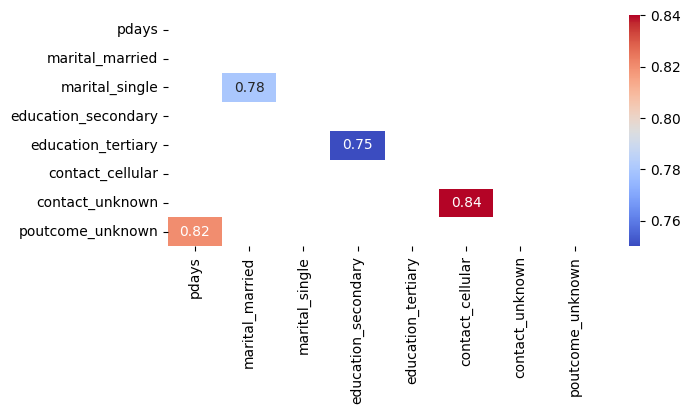

In [48]:
# heatmap
fig = plt.figure(figsize=(7, 3))
matrix = np.triu(pivot)
sns.heatmap(round(abs(pivot), 2), annot=True, cmap= 'coolwarm', mask=matrix);

Since the majority of correlation coefficients are below 0.9, we suppose there is no multicollinearity between features.

In [49]:
# data_encoded = data_encoded.drop(['contact_unknown', 'poutcome_unknown'], axis=1)
# data_encoded.head()

### Normalization

In [50]:
df_encoded = data_encoded.copy()
scaler = StandardScaler()
columns_to_process = ['age', 'balance']

temp = scaler.fit_transform(df_encoded[columns_to_process])
temp = pd.DataFrame(temp, columns = columns_to_process) 

df_encoded.drop(columns_to_process, axis=1, inplace=True)
df_encoded = df_encoded.merge(temp, left_index=True, right_index=True)
df_encoded.head(1)

#df_encoded['balance'] = temp[['balance']]

,default,housing,loan,campaign,pdays,previous,deposit,job_admin.,job_blue-collar,job_entrepreneur,...,age_group_60+,day_of_week_Mon,day_of_week_Tue,day_of_week_wed,day_of_week_Thu,day_of_week_Fri,day_of_week_Sat,day_of_week_Sun,age,balance
0,0,1,0,1,-1,0,1,1,0,0,...,0,0,0,0,0,0,1,0,1.542788,1.545522


### Split data

In [51]:
# Missing values identification
cols_null_percent = round(df_encoded.isnull().mean() * 100, 2)
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
print(f"Features with missing values, %: \n{cols_with_null}")

Features with missing values, %: 
Series([], dtype: float64)


In [52]:
X, y = df_encoded.drop(['deposit'], axis=1), df_encoded['deposit']

In [53]:
#X['balance'] = X['balance'].round(6)
#X['duration'] = X['duration'].round(6)
#X['age'] = X['age'].round(6)

In [54]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (7312, 56)
Test shape:  (914, 56)
Valid shape: (914, 56)


### Features selection

In [55]:
# # 15 Most meaningfull 15 features
# selector = SelectKBest(f_classif, k=15)
# selector.fit(X_train, y_train)

# features_out_kbest = selector.get_feature_names_out().tolist()
# print(features_out_kbest)

# # apply selection to X_train and X-test
# X_train, X_test = X_train[features_out_kbest], X_test[features_out_kbest]

In [56]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)                        
# X_train = scaler.transform(X_train) 
# X_test = scaler.transform(X_test)

# Modelling

### Log regression

In [57]:
models_dict = dict()

# def save_scores(model_name:str, models_dict=models_dict, y_valid=y_valid, y_pred=y_pred):
#     """Saving model name, f_1-score, ROC score to a dictionary

#     Args:
#         model_name (str): model name
#         models_dict (_type_, optional): dictionary to accumulate scores. Defaults to models_dict.
#         y_valid (_type_, optional): y values. Defaults to y_valid.
#         y_pred (_type_, optional): y_predicted values. Defaults to y_pred.

#     Returns:
#         _dict_: _description_
#     """    
#     model_f1_score, model_roc_score = f1_score(y_valid, y_pred).round(3), roc_auc_score(y_valid, y_pred).round(3)
    
#     models_dict.update({model_name: [model_f1_score, model_roc_score]})
    
#     return models_dict

In [58]:
def get_ROC_plot(model, X_valid, y_valid, title:str, fig_id:int=None):
    """
    Create the roc curve plot
    Args:
        model (_type_): pre-trained model to get prediction
        X_valid (_type_): X matrice with 
        y_valid (_type_): y predicted values
        title (_type_): _description_
        figpath (_int_): figure path for saving
    """
    y_pred = model.predict_proba(X_valid)[:,1]
    print('roc_auc: ', roc_auc_score(y_valid, y_pred).round(3))

    false_positive_rates, true_positive_rates, threshold = roc_curve(y_valid, y_pred)


    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))

    # ROC curve
    ax.plot(false_positive_rates, true_positive_rates, 
            label='Smoothed values ROC-AUC')

    # Random model
    ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
            label='Model predicting random')

    ax.set_title(f'Fig.{fig_id} - ROC curve for {title}', y=-0.2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    ax.fill_between(false_positive_rates, 
                    true_positive_rates, 
                    step="pre", 
                    alpha=0.4, label='Area under curve (ROC-AUC)')
     
    ax.legend()
    plt.tight_layout()
    
    
    # Annotate figure with ROC cureve
    plt.annotate(f'ROC: {roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]).round(3)}', xy=(0.45,0.6), textcoords='data', 
             bbox={'facecolor': 'w', 'alpha': 0.95, 'pad': 10} 
    );
    
    if fig_id:
        plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

In [59]:
log_reg = LogisticRegression(
    solver='sag', 
    max_iter=2000,
    random_state=random_seed)

# train model
log_reg.fit(X_train, y_train) 

# Predict target values
y_pred = log_reg.predict(X_valid)

# Metrics report
print(metrics.classification_report(y_valid, y_pred))

#get_ROC_plot(log_reg, X_valid, y_valid, 'Logistic regression') #, fig_id=3
models_dict.update({'log_reg': [
    f1_score(y_valid, y_pred).round(3), 
    roc_auc_score(y_valid, log_reg.predict_proba(X_valid)[:,1]).round(3)
]})

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       436
           1       0.72      0.68      0.70       478

    accuracy                           0.70       914
   macro avg       0.70      0.70      0.70       914
weighted avg       0.70      0.70      0.70       914



### Decision tree

In [60]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy', # criterion
    max_depth=6,  
    min_samples_leaf = 10, 
    random_state=random_seed 
)
# train model
dt.fit(X_train, y_train)
 
# Predict target values
y_pred = dt.predict(X_valid)

# Metrics report
print(metrics.classification_report(y_valid, y_pred))

 
models_dict.update({'dt': [
    f1_score(y_valid, y_pred).round(3), 
    roc_auc_score(y_valid, dt.predict_proba(X_valid)[:,1]).round(3)
]})

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       436
           1       0.74      0.58      0.65       478

    accuracy                           0.67       914
   macro avg       0.68      0.68      0.67       914
weighted avg       0.68      0.67      0.67       914



### Optimization using Gridsearch

In [61]:
parameters =  {'min_samples_split': [2, 5, 7, 10,12], 'max_depth':[3,5,7,12]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), 
                        parameters,
                        scoring=('f1'), 
                        return_train_score=True)
# search parameters
%time model_cv.fit(X_train, y_train)
 
# Predict target values
y_pred_gs = model_cv.predict(X_valid)

# Metrics report
print(metrics.classification_report(y_valid, y_pred_gs))

print("Best parameters: {}".format(model_cv.best_params_))

models_dict.update({'dt_opt': [
    f1_score(y_valid, y_pred_gs).round(3), 
    roc_auc_score(y_valid, y_pred_gs).round(3)
]})

CPU times: total: 3.38 s
Wall time: 3.38 s
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       436
           1       0.74      0.65      0.69       478

    accuracy                           0.70       914
   macro avg       0.70      0.70      0.70       914
weighted avg       0.70      0.70      0.70       914

Best parameters: {'max_depth': 12, 'min_samples_split': 12}


### Random forest

In [62]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=random_seed
)

# train model
rf.fit(X_train, y_train)
 
# Predict target values
y_pred_rf = rf.predict(X_valid)

# Metrics report
print(metrics.classification_report(y_valid, y_pred_rf ))

models_dict.update({'rf': [
    f1_score(y_valid, y_pred_rf).round(3), 
    roc_auc_score(y_valid, y_pred_rf ).round(3)
]})

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       436
           1       0.77      0.68      0.72       478

    accuracy                           0.73       914
   macro avg       0.73      0.73      0.73       914
weighted avg       0.73      0.73      0.73       914



### Gradient boosting

In [63]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=random_seed
)

# train model
gb.fit(X_train, y_train)
 
# Predict target values
y_pred_gb = gb.predict(X_valid)

# Metrics report
print(metrics.classification_report(y_valid, y_pred_gb))

models_dict.update({'gb': [
    f1_score(y_valid, y_pred_gb).round(3), 
    roc_auc_score(y_valid, gb.predict_proba(X_valid)[:,1]).round(3)
]})

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       436
           1       0.79      0.67      0.73       478

    accuracy                           0.74       914
   macro avg       0.74      0.74      0.74       914
weighted avg       0.74      0.74      0.74       914



### Gradient boosting + optuna

In [64]:
def optuna_gb(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 350, 450, 1)
    max_depth = trial.suggest_int('max_depth', 5, 15, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 15, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_valid)[:,1])
    F1_score = f1_score(y_valid, y_pred)
    roc_score = roc_auc_score(y_valid, y_pred)
    
    return F1_score, roc_score

In [65]:
%%time
# create study set
study = optuna.create_study(study_name="GradientBoostingClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=20)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

CPU times: total: 3min 46s
Wall time: 3min 46s


In [66]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 1
Trial with highest accuracy: 
	params: {'n_estimators': 448, 'max_depth': 7, 'min_samples_leaf': 10, 'learning_rate': 0.022947380045572126}


In [67]:
# Apply best parameters
gb_opt_cl = GradientBoostingClassifier(**best_hyperparameters.params, random_state=random_seed) #study.best_params
gb_opt_cl.fit(X_train, y_train)

# Predict target values
y_pred_gb_optu, y_pred_rf_optu_test = gb_opt_cl.predict(X_valid), gb_opt_cl.predict(X_test)

# Metrics report
print(metrics.classification_report(y_valid, y_pred_gb_optu))

models_dict.update({'gb_opt_cl': [
    f1_score(y_valid, y_pred_gb_optu).round(3), 
    roc_auc_score(y_valid, gb_opt_cl.predict_proba(X_valid)[:,1]).round(3)
]})

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       436
           1       0.78      0.67      0.72       478

    accuracy                           0.73       914
   macro avg       0.74      0.73      0.73       914
weighted avg       0.74      0.73      0.73       914



### Stacking

In [68]:
estimators = [
    
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=2,
        max_depth=6,
        random_state=random_seed
        )
    ),
    ('dt2', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=2,
        max_depth=10,
        random_state=random_seed
        )
    ),
    ('log_reg', LogisticRegression(
        solver='sag',
        random_state=random_seed
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=random_seed
        )
    )
]

stack = StackingClassifier(
    estimators,
    final_estimator=LogisticRegression(random_state=random_seed)
)
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('dt2',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [69]:
# Predict target values
y_pred_st = stack.predict(X_valid)

# Metrics report
print(metrics.classification_report(y_valid, y_pred_st))

models_dict.update({'stack': [
    f1_score(y_valid, y_pred_st).round(3), 
    roc_auc_score(y_valid, stack.predict_proba(X_valid)[:,1]).round(6)
]})

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       436
           1       0.77      0.69      0.73       478

    accuracy                           0.73       914
   macro avg       0.73      0.73      0.73       914
weighted avg       0.74      0.73      0.73       914



### Stacking + tuning

In [70]:
def optuna_st(trial):
    """
  Hyperparameters optimization for stacking regressor model

  Args:
      trial (_type_): iteration

  Returns:
      F1_score
      """
    # set dimensions
    #min_samples_leaf1 = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    #min_samples_leaf2 = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    n_estimators = trial.suggest_int('n_estimators', 350, 450, 1)
    max_depth = trial.suggest_int('max_depth', 5, 15, 1)
    
    estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        #min_samples_leaf=min_samples_leaf1,
        max_depth=6,
        random_state=random_seed
        )
    ),
    ('dt2', tree.DecisionTreeClassifier(
        criterion='entropy',
        #min_samples_leaf=min_samples_leaf2,
        max_depth=10,
        random_state=random_seed
        )
    ),
    ('log_reg', LogisticRegression(
        solver='sag',
        random_state=random_seed
        )
    ),
    ('gb', GradientBoostingClassifier(
        random_state=random_seed
        )
    )]

    # model creation 
    model = StackingClassifier(
        estimators=estimators,
        final_estimator=RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth,
            random_state=random_seed)
    )
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_valid)[:,1])
    F1_score = f1_score(y_valid, y_pred)
    roc_score = roc_auc_score(y_valid, y_pred)
    
    return F1_score, roc_score

In [71]:
%%time
# create study set
study = optuna.create_study(study_name="Stack", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_st, n_trials=20)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

CPU times: total: 3min 23s
Wall time: 3min 23s


In [72]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 5
Trial with highest accuracy: 
	params: {'n_estimators': 387, 'max_depth': 5}


In [73]:
estimators = [
    
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        #min_samples_leaf=2,
        #max_depth=6,
        random_state=random_seed
        )
    ),
    ('dt2', tree.DecisionTreeClassifier(
        criterion='entropy',
        #min_samples_leaf=2,
        #max_depth=10,
        random_state=random_seed
        )
    ),
    ('log_reg', LogisticRegression(
        solver='sag',
        random_state=random_seed
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        #learning_rate=0.05,
        #n_estimators=300,
        #min_samples_leaf=5,
        #max_depth=5,
        random_state=random_seed
        )
    )
]

stack_opt = StackingClassifier(
    estimators,
    final_estimator=RandomForestClassifier(**best_hyperparameters.params, random_state=random_seed)
)
stack_opt.fit(X_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42)),
                               ('dt2',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(max_depth=5,
                                                          n_estimators=387,
                                                          random_state=42))

In [74]:
# Predict target values
y_pred_st_opt = stack.predict(X_valid)

# Metrics report
print(metrics.classification_report(y_valid, y_pred_st_opt))

#get_ROC_plot(stack_opt, X_valid, y_valid, 'Stack + Optuna', fig_id=14) #, fig_id=3

models_dict.update({'stack_opt': [
    f1_score(y_valid, y_pred_st_opt).round(3), 
    roc_auc_score(y_valid, stack_opt.predict_proba(X_valid)[:,1]).round(6)
]})

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       436
           1       0.77      0.69      0.73       478

    accuracy                           0.73       914
   macro avg       0.73      0.73      0.73       914
weighted avg       0.74      0.73      0.73       914



In [75]:
# Extract values from dict to array
model_names, f1_scores_arr, roc_scores_arr = list(), np.array([],dtype=np.float32), np.array([],dtype=np.float32)
for k,v in models_dict.items():
    
    f1_scores_arr = np.append(f1_scores_arr, [v[0]], axis=0)
    roc_scores_arr = np.append(roc_scores_arr, [v[1]], axis=0)

print(f'Best model name: {list(models_dict)[np.argmax(roc_scores_arr)]}, \
    f1_score: {f1_scores_arr[np.argmax(f1_scores_arr)]}, \
    ROC_csore: {roc_scores_arr[np.argmax(f1_scores_arr)].round(3)}'
)

Best model name: stack,     f1_score: 0.729,     ROC_csore: 0.786


In [76]:
models_dict

{'log_reg': [0.702, 0.759],
 'dt': [0.646, 0.727],
 'dt_opt': [0.694, 0.701],
 'rf': [0.724, 0.731],
 'gb': [0.728, 0.783],
 'gb_opt_cl': [0.724, 0.781],
 'stack': [0.729, 0.785867],
 'stack_opt': [0.729, 0.783269]}

Best model name: stack,     
f1_score: 0.729,     
ROC_csore: 0.786

| Model | ROC AUC score | Weighted average <br> f1-score |
:- | :--: | :--:
| Logistic regression | 0.7 | 0.76 |
| Decision tree | 0.65 | 0.73 |
| Random Forest | 0.72 | 0.73 |
| Gradient Boosting | 0.73 | 0.78 |
| Gradient Boosting + Optuna | 0.72 | 0.79 |
| Stacking model | <mark>0.73</mark> | 0.79 |
| Stacking model + Optuna | 0.73 | 0.78 |

### Save model

In [77]:
list(models_dict)[np.argmax(roc_scores_arr)]

'stack'

In [125]:
for file in os.listdir("../models/"):
    if file.endswith(".pkl"):
        #print(os.path.join("../models/", file))
        best_model = os.path.join("../models/", file)
best_model

'../models/stack.pkl'

In [122]:
# Save model to the given path in the pkl format

full_path = os.path.join(path_models, 'stack.pkl') #'.pkl'

with open(full_path, 'wb') as f:
    pickle.dump(stack, f)

In [123]:
# recover saved model
with open(full_path, 'rb') as f:
    model_load = pickle.load(f)

## Model study

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       436
           1       0.77      0.67      0.72       478

    accuracy                           0.73       914
   macro avg       0.73      0.73      0.73       914
weighted avg       0.73      0.73      0.72       914

roc_auc:  0.783


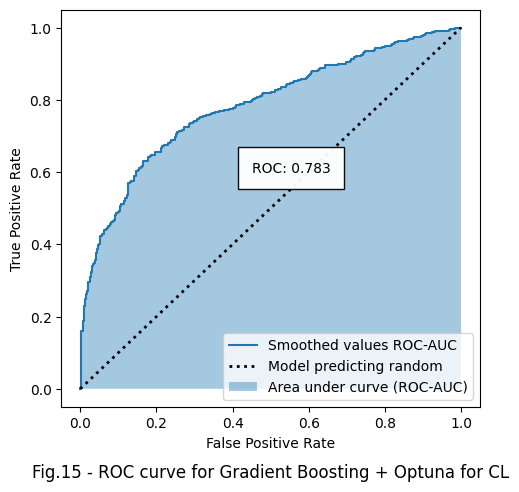

In [234]:
y_pred = model_load.predict(X_valid)
y_prob = model_load.predict_proba(X_valid)
# Metrics report
print(metrics.classification_report(y_valid, y_pred))

fig_id=15
get_ROC_plot(gb_opt_cl, X_valid, y_valid, 'Gradient Boosting + Optuna for CL',fig_id=fig_id) #, 

false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_pred)

## Feature selection

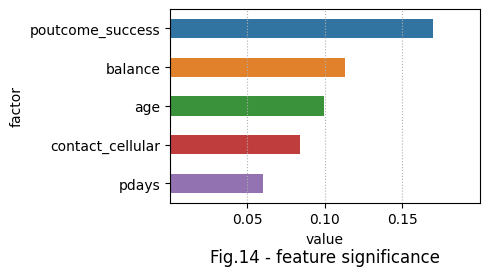

In [ ]:
# arrays names and values
f_keys, f_values = np.array(X_train.columns), gb.feature_importances_
# sort and reverse arrays
idx   = np.argsort(f_values)[::-1]

f_keys, f_values = np.array(f_keys)[idx], np.array(f_values)[idx]

# Table
f_keys, f_values = np.array(f_keys)[idx], np.array(f_values)[idx]

factors = pd.DataFrame({'factor':f_keys,
              'value':f_values
}).sort_values(by='value', ascending=False).head(5)

fig_id=14

# display a bar chart
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='value', y='factor', width=0.5)
#ax.grid()
ax.set_title(f'Fig.{fig_id} - feature significance', y=-0.35); 
plt.tight_layout()
major_ticks = np.linspace(0.05, 0.15, 3)
ax.set_xticks(major_ticks)
ax.set_xlim(0,0.2)
ax.xaxis.grid(linestyle=':');

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))